In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#download timeseries data
timeseries_df = pd.read_csv("data/df_timeseries_en.tsv.gz", sep='\t', compression="gzip", parse_dates=["datetime"])
timeseries_df.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.000000,395.777778,6,1,1


In [3]:
#download channels data
channel_df = pd.read_csv("data/df_channels_en.tsv.gz", sep='\t', compression="gzip")
channel_df.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


### Calculate and fix metrics (change this description)

In [4]:
ts_grouped_by_channel = timeseries_df.groupby('channel')

# calculate cumulative views per channel
timeseries_df["cumviews"] = ts_grouped_by_channel["views"].cumsum()

# because negative delta views are not included in the original dataset, we recalculated them
timeseries_df["delta_views"] = ts_grouped_by_channel["views"].diff().fillna(0)

## Significative channels visualization

#### Overnight success followed by downfall

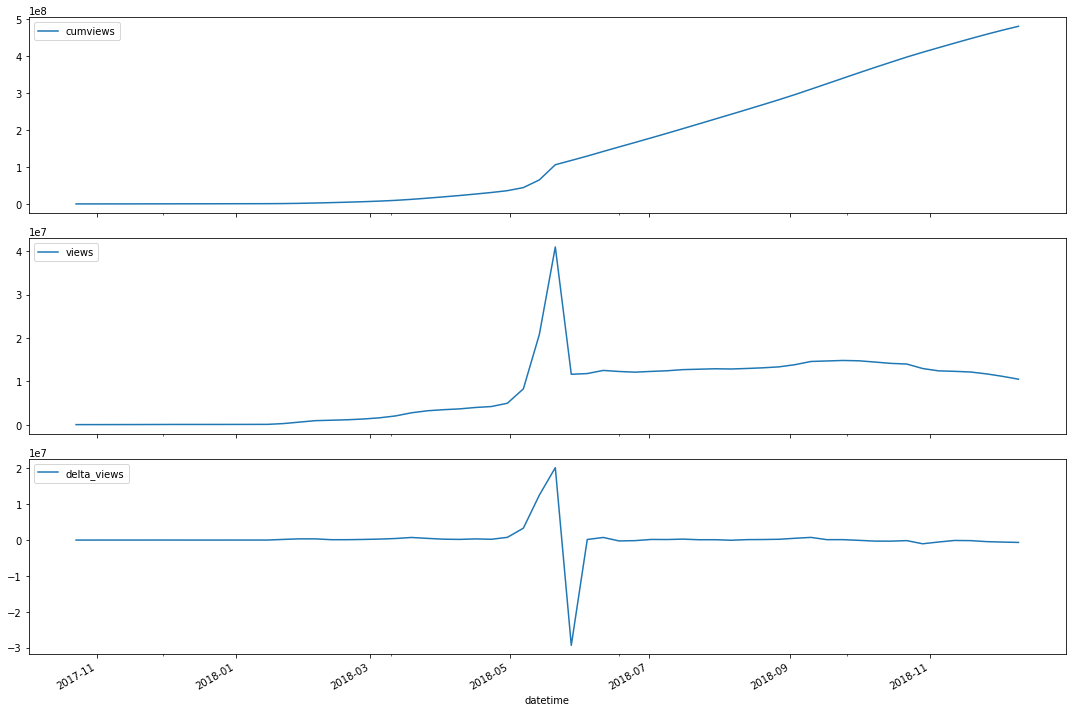

In [5]:
current_channel = 'UCj-R_ePoJvWGiLOD6aDgMSg'

fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axs_flat = axs.ravel()

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0])
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1])
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2])

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

add explanation here to explain why this is a good example and what distinguishes it from the others, what are the features we are looking for, ...

#### Overnight success followed by stability

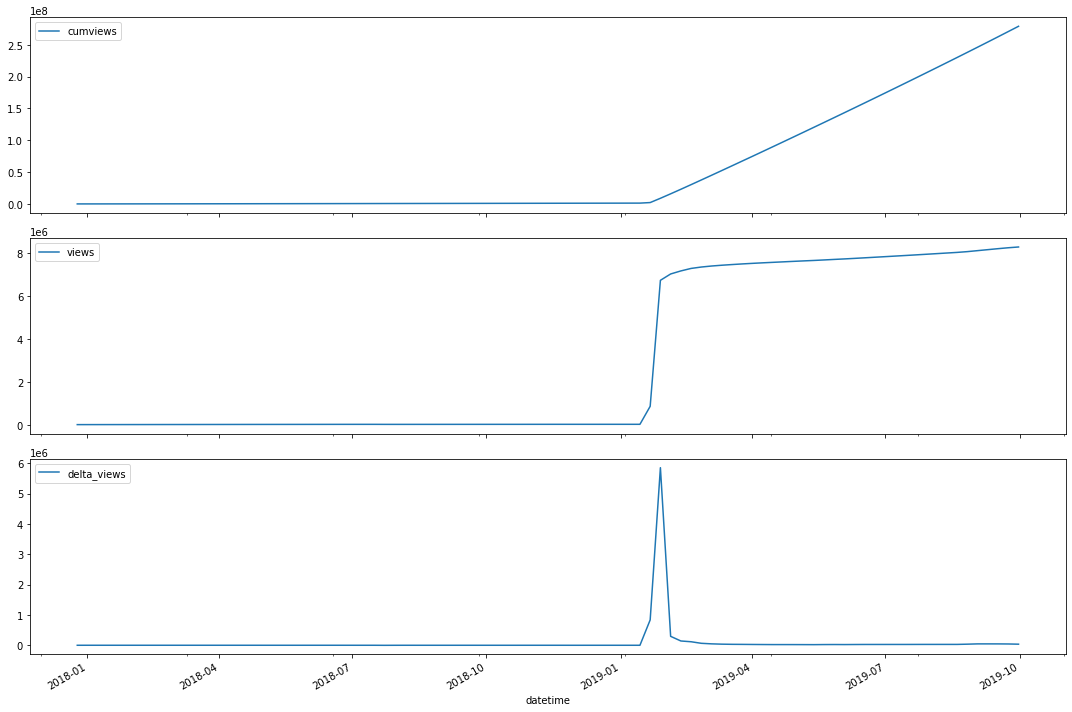

In [6]:
current_channel = 'UCa4hfBXGDC_TxUHTEbCdyng'

fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axs_flat = axs.ravel()

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0])
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1])
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2])

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

add explanation here to explain why this is a good example and what distinguishes it from the others, what are the features we are looking for, ...

# Population division

### Step 1: Calculate meaningful metrics

##### Metric 1: Views variability

In [7]:
max_views = ts_grouped_by_channel['views'].max()
min_views = ts_grouped_by_channel['views'].min()

variability = (max_views - min_views) / max_views
variability.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    0.985649
UC--2EbuIuBOGgGqPiJxi3rg    0.624639
Name: views, dtype: float64

##### Metric 2: Channel growth

In [8]:
begin, end = ts_grouped_by_channel['views'].first(), ts_grouped_by_channel['views'].last()

growth = (end - begin) / begin
growth.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    68.681544
UC--2EbuIuBOGgGqPiJxi3rg     1.664100
Name: views, dtype: float64

##### Metric 3: Views growth steepness

In [9]:
delta_max = ts_grouped_by_channel["delta_views"].max()

growth_steepness = delta_max / max_views
growth_steepness.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    0.173725
UC--2EbuIuBOGgGqPiJxi3rg    0.008063
dtype: float64

In [10]:
metrics = pd.DataFrame({
    "growth_steepness": growth_steepness,
    "growth": growth,
    "variability": variability
}).reset_index()
metrics.head(2)

,channel,growth_steepness,growth,variability
0,UC--24Q3_ZQeFmgJE-Um5QZQ,0.173725,68.681544,0.985649
1,UC--2EbuIuBOGgGqPiJxi3rg,0.008063,1.664100,0.624639


In [11]:
channel_df = channel_df.merge(metrics, on="channel")
channel_df.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087,0.009504,0.734529,0.423474
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087,0.030208,32.727533,0.970351


### Step 2: Divide population using the metrics

In [12]:
growth_bound = 0.2

# select channels with a growth between -0.2 and 0.2
lose_fame = channel_df[(-growth_bound < channel_df["growth"]) & (channel_df["growth"] < growth_bound)]

# keep only channels with a growth greater than 0.2 because we're not interested in those who lost fame
keep_fame = channel_df[channel_df["growth"] > growth_bound]

#### Initial exploratory data analysis
We added the metrics for further filtering but we still need to quantify the threshold.  
Ideally we want to select channels with a high variability and a high growth steepness so ordering them by those metrics and selecting the top 10% should be a good start for an initial exploratory data analysis

### Step 3: Further, and more accurate, filtering

In [13]:
import scipy.integrate as integrate

def growth_rate_per_channel(df_timeseries):
    sliding_window = 5

    times = []
    integrals = []
    for i in range(len(df_timeseries['views']) - sliding_window):
        window = df_timeseries['views'][i:i+sliding_window]
        b, e = window.iloc[0], window.iloc[-1]

        if e < b:
            continue

        line = np.array([(e - b) * j / (sliding_window - 1) + b for j in range(sliding_window)])

        # since we are measuring the sudden increase in views as an integral of the difference between the linear increase and the actual increase,
        # we have to make sure that the linear increase is above the actual increase at least at the beginning of the window
        if window.iloc[1] > line[1]:
            continue

        if integrate.simpson(line - window) > 0:
            # FIXME: add importance of the absolute value difference of values instead of only the area
            integrals.append(integrate.simpson(np.abs(line - window)) / integrate.simpson(line))
            times = times + [df_timeseries['datetime'].iloc[i]]

    integrals = integrals + [0]
    times = times + [df_timeseries['datetime'].iloc[0]]
    
    _max = np.argmax(integrals)
    return pd.Series([times[_max], integrals[_max]])

In [16]:
# calculate the sudden increase in views for each channel
keep_fame_ts = timeseries_df[timeseries_df["channel"].isin(keep_fame["channel"])]
keep_fame_sudden_growth = keep_fame_ts.groupby('channel').apply(growth_rate_per_channel).rename(columns={0: 'sudden_growth_date', 1: 'sudden_growth_index'})

lose_fame_ts = timeseries_df[timeseries_df["channel"].isin(lose_fame["channel"])]
lose_fame_sudden_growth = lose_fame_ts.groupby('channel').apply(growth_rate_per_channel).rename(columns={0: 'sudden_growth_date', 1: 'sudden_growth_index'})

#### Initial exploratory data analysis
Same as above, we want to analyze the channels comparing them by growth steepness, so further filtering using the new calculated metric should be done to additionally narrow the populations

In [18]:
#adding the sudden growth informations in the channels dataframe
keep_fame = keep_fame.merge(keep_fame_sudden_growth, on="channel")
lose_fame = lose_fame.merge(lose_fame_sudden_growth, on="channel")
lose_fame.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,sudden_growth_date,sudden_growth_index
0,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087,0.007550,0.133989,0.118157,2019-04-15 00:00:00,0.003121
1,Entertainment,2008-06-01,UCYvmuw-JtVrTZQ-7Y4kd63Q,Katy Perry,35028528,101,30.0,2.087,0.047522,0.138656,0.121772,2017-05-15 00:00:00,0.020118
2,Music,2008-04-04,UCsRM0YB_dabtEPGPTKo-gcw,Adele,20289957,13,127.0,2.087,0.003157,0.108009,0.097480,2016-12-18 23:00:00,0.000973
3,Music,2006-12-20,UCcYrdFJF7hmPXRNaWdrko4w,ChrisBrownTV,17500000,18,163.0,2.087,0.005291,0.138275,0.121478,2018-12-30 23:00:00,0.002036
4,People & Blogs,2008-05-15,UCNL1ZadSjHpjm4q9j2sVtOA,Lady Gaga,14495273,163,238.0,2.087,0.005532,0.157662,0.136190,2019-06-17 00:00:00,0.002048


In [15]:
#load the video datas from json file

dfs_video = []
for df_json in pd.read_json('data/yt_metadata_en.jsonl.gz', compression="gzip", chunksize=1000000, lines=True):
    df_json.drop(["description", "crawl_date", "dislike_count"], inplace=True, axis=1)
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[df_json['upload_date'] >= pd.to_datetime('2015-01-01')]

    dfs_video.append(df_json)
df_final = pd.concat(dfs_video)


KeyboardInterrupt



In [ ]:
df_final.rename(columns={'channel_id': 'channel'})
videos_df = pd.merge(channel_df, df_final, on="channel", how="outer")
video_gby_channel = videos_df.groupby(["channel_id"]).mean()

In [ ]:
#laod the video datas without 'title', 'description', and 'tags' columns
df_videos = pd.read_feather("data/yt_metadata_helper.feather")
df_videos["upload_date"] = pd.to_datetime(df_videos["upload_date"])
df_videos = df_videos[df_videos['upload_date'] > pd.to_datetime('2015-01-01')]
df_videos.head()

In [ ]:
#rename for merge and merge
df_videos.rename(columns={'channel_id': 'channel'})
videos_keep = df_videos.merge(keep_fame, on='channel')
videos_lose = df_videos.merge(lose_fame, on='channel')

#separating before and after sudden growth
video_lose_before = videos_lose[videos_lose['sudden_growth_date'] > videos_lose['datetime']]
video_lose_after = videos_lose[videos_lose['sudden_growth_date'] < videos_lose['datetime']]
video_keep_before = videos_keep[videos_keep['sudden_growth_date'] > videos_keep['datetime']]
video_keep_after = videos_keep[videos_keep['sudden_growth_date'] < videos_keep['datetime']]

#taking the mean for each channel
videos_keep_before.groupby(['channel']).mean()
videos_keep_after.groupby(['channel']).mean()
videos_lose_before.groupby(['channel']).mean()
videos_lose_after.groupby(['channel']).mean()

videos_lose_after.head()

In [ ]:
#adding to channel datas the mean duration
temp = videos_lose_before[['channel','duration']]
ch_lose_before = lose_fame.merge(temp, on="channel")
temp = videos_lose_after[['channel','duration']]
ch_lose_after = lose_fame.merge(temp, on="channel")
temp = videos_keep_after[['channel','duration']]
ch_keep_after = keep_fame.merge(temp, on="channel")
temp = videos_keep_before[['channel','duration']]
ch_keep_before = lose_fame.merge(temp, on="channel")

In [ ]:
#statistics about the changes before and after the sudden growth
import scipy.stats as scs

scs.ttest_ind(ch_lose_before['duration'], ch_lose_after['duration'])
scs.ttest_ind(ch_keep_before['duration'], ch_keep_after['duration'])

In [19]:
#merging the channel datas to the corresponding timeseries
keep_fame_ts = pd.merge(keep_fame, keep_fame_ts, on="channel")
lose_fame_ts = pd.merge(lose_fame, lose_fame_ts, on="channel")
keep_fame_ts.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,...,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,cumviews
0,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087,0.00755,0.133989,...,Entertainment,2016-10-10 00:00:00,5.565525e+08,0.00000,3.073868e+06,0.000000,125,0,0,5.565525e+08
1,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087,0.00755,0.133989,...,Entertainment,2016-10-17 00:00:00,5.568376e+08,285187.87500,3.075458e+06,1589.875000,125,0,0,1.113390e+09
2,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087,0.00755,0.133989,...,Entertainment,2016-10-24 00:00:00,5.570804e+08,242709.25000,3.076663e+06,1204.875000,125,0,0,1.670470e+09
3,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087,0.00755,0.133989,...,Entertainment,2016-10-30 23:00:00,5.573140e+08,233673.28886,3.077977e+06,1313.679404,125,0,0,2.227784e+09
4,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087,0.00755,0.133989,...,Entertainment,2016-11-06 23:00:00,5.575503e+08,236226.89864,3.079373e+06,1396.846638,125,0,0,2.785335e+09


In [31]:
keep_fame_ts.dtypes

category_cc                      object
join_date                        object
channel                          object
name_cc                          object
subscribers_cc                    int64
videos_cc                         int64
subscriber_rank_sb              float64
weights                         float64
growth_steepness                float64
growth                          float64
variability                     float64
sudden_growth_date_x     datetime64[ns]
sudden_growth_index_x           float64
sudden_growth_date_y     datetime64[ns]
sudden_growth_index_y           float64
category                         object
datetime                 datetime64[ns]
views                           float64
delta_views                     float64
subs                            float64
delta_subs                      float64
videos                            int64
delta_videos                      int64
activity                          int64
cumviews                        float64


In [32]:
#separating data before and after sudden growth
ts_lose_before = lose_fame_ts[lose_fame_ts['sudden_growth_date'] > lose_fame_ts['datetime']]
ts_lose_after = lose_fame_ts[lose_fame_ts['sudden_growth_date'] < lose_fame_ts['datetime']]
ts_keep_before = keep_fame_ts[keep_fame_ts['sudden_growth_date'] >= keep_fame_ts['datetime']].copy()
ts_keep_after = keep_fame_ts[keep_fame_ts['sudden_growth_date'] <= keep_fame_ts['datetime']].copy()

In [33]:
#mean of the timeseries datas by channel
ts_lose_before.groupby(['channel']).mean()
ts_lose_after.groupby(['channel']).mean()
ts_keep_before.groupby(['channel']).mean()
ts_keep_after.groupby(['channel']).mean()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,sudden_growth_index,views,delta_views,subs,delta_subs,videos,delta_videos,activity,cumviews
channel,,,,,,,,,,,,,,,,
UC--oI-BYTJVWNgq3l5QihNQ,26400.0,61.0,437090.0,9.0190,0.008161,0.015071,0.176519,0.004487,1.008772e+07,-12589.077640,25512.650844,123.653382,58.434783,0.304348,0.739130,1.773832e+09
UC-1-Igc4_8_WRPW6wrs57Cg,12300.0,10.0,847847.0,14.8005,0.003836,0.177296,0.150596,0.001266,1.365196e+07,8745.927084,11658.246320,13.955136,6.848276,0.027586,0.068966,1.403494e+09
UC-3Oc4KY7pElZMbsWtm3X6A,173970.0,641.0,93519.0,3.9165,0.008966,0.165937,0.172198,0.004332,9.397026e+06,5222.569600,172024.814756,86.113579,592.485714,1.007143,2.264286,7.931240e+08
UC-3k0L1qlTg3jzJF_AvyYrA,382000.0,1148.0,48547.0,3.4000,0.000749,0.027209,0.026489,0.000371,1.456564e+08,22562.387511,384676.511192,13.573377,1114.450000,0.492857,1.050000,1.252531e+10
UC-4O8ofliKptH6Yo7WWQzFQ,27300.0,310.0,473526.0,8.8075,0.008377,0.156034,0.134973,0.002567,8.564900e+06,4845.980958,27739.030055,5.334937,297.048276,0.393103,0.848276,7.519986e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UCzwKYrHroAYBh4bOrgovtMA,12800.0,162.0,771907.0,11.0630,0.002443,0.153259,0.132892,0.001059,1.553469e+06,1104.294196,13098.591674,0.781928,156.942857,0.142857,0.357143,1.577500e+08
UCzwnUEmVsMOrtR2rlLkNnSQ,17300.0,665.0,659477.0,8.0620,0.003225,0.182621,0.154420,0.001186,5.179119e+06,3732.481771,16641.399592,12.584237,627.692857,0.592857,1.364286,5.525585e+08
UCzyu0YDMQB_5iSGPOXECcHQ,20860.0,11.0,584865.0,9.9125,0.140074,-0.109442,0.784609,0.103856,4.555033e+06,-30978.085227,20739.818985,46.086368,0.000000,0.000000,0.000000,4.374430e+08


In [34]:
#adding to channel datas the mean activity 
temp = ts_lose_before[['channel', 'activity']]
channel_lose_before = lose_fame.merge(temp, on="channel")
temp = ts_lose_after[['channel', 'activity']]
channel_lose_after = lose_fame.merge(temp, on="channel")
temp = ts_keep_before[['channel', 'activity']]
channel_keep_before = keep_fame.merge(temp, on="channel")
temp = ts_keep_after[['channel', 'activity']]
channel_keep_after = keep_fame.merge(temp, on="channel")

In [37]:
#statistics on activity before and after
import scipy.stats as scs

scs.ttest_ind(channel_lose_before['activity'], channel_lose_after['activity'])
scs.ttest_ind(channel_keep_before['activity'], channel_keep_after['activity'])

Ttest_indResult(statistic=-9.164373009333113, pvalue=4.998014931077381e-20)